## Synopsis

Pymaceuticals needs to have their research data analyzed and plotted for new cancer treament drugs. In this data set, 248 mice were used to analyze 10 drug regimens (incliuding a placebo). Four of the regimens were selected to summarize and plot the results of the research. The selected drug regimens are: Capomulin, Ramicane, Infubinol, and Ceftamin.

## Observations and Insights 

There is a strong correlation between weight and tumor size (e.g The greater the mouse weight, the larger the tumor).
Over time, Capomulin dramatically reduced the tumor volume in Mouse m957. 
Capomulin and Ramicane have similiar quartile results while Infubinol and Ceftamin's results are similar to each other. The later pair had much higher tumor volumes after the final treatments. Only Infubinol had a final tumor volume that was outside the expected range. It would seem that Capomulin and Ramicane are much more effective in reducing tumor growth.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
#Using some tips from StackOverflow to suppress warnings
#https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_study_complete = pd.merge(mouse_metadata, study_results, how="outer", on="Mouse ID")
# Display the data table information
mouse_study_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mouse ID            1893 non-null   object 
 1   Drug Regimen        1893 non-null   object 
 2   Sex                 1893 non-null   object 
 3   Age_months          1893 non-null   int64  
 4   Weight (g)          1893 non-null   int64  
 5   Timepoint           1893 non-null   int64  
 6   Tumor Volume (mm3)  1893 non-null   float64
 7   Metastatic Sites    1893 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 133.1+ KB


In [2]:
# Display the data table for preview
mouse_study_complete

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [3]:
# Checking the number of mice.
mouse_count = mouse_study_complete["Mouse ID"].value_counts()
len(mouse_count)

249

In [4]:
#Finding the mouse that has duplicate timepoints 
dup_mouseid_timepoints = mouse_study_complete[mouse_study_complete.duplicated(["Mouse ID", "Timepoint"])]
dup_mouseid = dup_mouseid_timepoints["Mouse ID"].unique()
dup_mouseid


array(['g989'], dtype=object)

In [5]:
# All the rows of data for the mouse that had duplicate time points
mouse_with_duplicates = mouse_study_complete.loc[mouse_study_complete["Mouse ID"] == "g989"]
mouse_with_duplicates

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Creating a clean DataFrame by dropping the duplicate mouse by its ID.
remove_mouse = mouse_study_complete[ mouse_study_complete["Mouse ID"] == "g989"].index
mouse_study_complete.drop(remove_mouse, inplace=True)
mouse_study_cleaned = mouse_study_complete.reset_index()
#All rows of data removed for mouseID with duplicate timeponts
len(mouse_study_cleaned)

1880

In [7]:
# Checking the number of mice in the clean DataFrame.
mouse_count_check = mouse_study_cleaned["Mouse ID"].value_counts()
len(mouse_count_check)
#Mouse Removed

248

## Summary Statistics

### Method One

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.

In [9]:
mouse_study_mean = mouse_study_cleaned.groupby("Drug Regimen").mean()

In [10]:
mouse_study_med = mouse_study_cleaned.groupby("Drug Regimen").median()

In [11]:
mouse_study_var = mouse_study_cleaned.groupby("Drug Regimen").var()

In [12]:
mouse_study_std = mouse_study_cleaned.groupby("Drug Regimen").std()

In [13]:
mouse_study_sem = mouse_study_cleaned.groupby("Drug Regimen").sem()

In [14]:
#Combining the summary tables and renaming the columns
first_merge = pd.merge(mouse_study_mean["Tumor Volume (mm3)"], mouse_study_med["Tumor Volume (mm3)"], on="Drug Regimen")
first_renamed = first_merge.rename(columns={"Tumor Volume (mm3)_x":"Tumor Volume Mean", "Tumor Volume (mm3)_y":"Tumor Volume Median"})
var_merge = pd.merge(first_renamed, mouse_study_var["Tumor Volume (mm3)"], on="Drug Regimen")
var_renamed = var_merge.rename(columns={"Tumor Volume (mm3)":"Tumor Volume Variance"})
std_merge = pd.merge(var_renamed, mouse_study_std["Tumor Volume (mm3)"], on="Drug Regimen")
std_renamed = std_merge.rename(columns={"Tumor Volume (mm3)":"Tumor Volume Standard Deviation"})
sem_merge = pd.merge(std_renamed, mouse_study_sem["Tumor Volume (mm3)"], on="Drug Regimen")
tumor_volume_summary = sem_merge.rename(columns={"Tumor Volume (mm3)":"Tumor Volume SEM"})
tumor_volume_summary

,Tumor Volume Mean,Tumor Volume Median,Tumor Volume Variance,Tumor Volume Standard Deviation,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


### Method Two

In [15]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
mouse_study_summary = mouse_study_cleaned.groupby("Drug Regimen")
#Using a single function rather than merging multiple tables
tumor_volume_summary = mouse_study_summary["Tumor Volume (mm3)"].agg([np.mean, np.median, np.var, np.std, st.sem])
tumor_volume_summary = tumor_volume_summary.rename(columns={"mean":"Tumor Volume Mean",
                                                            "median":"Tumor Volume Median",
                                                            "var":"Tumor Volume Variance",
                                                            "std":"Tumor Volume Standard Deviation",
                                                            "sem":"Tumor Volume SEM"})
tumor_volume_summary

,Tumor Volume Mean,Tumor Volume Median,Tumor Volume Variance,Tumor Volume Standard Deviation,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

In [16]:
# Find the count of mice used for each drug regimen
mouse_study_count = mouse_study_cleaned.groupby(["Drug Regimen"])["Mouse ID"].count()
mouse_study_count

Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    178
Ketapril     188
Naftisol     186
Placebo      181
Propriva     148
Ramicane     228
Stelasyn     181
Zoniferol    182
Name: Mouse ID, dtype: int64

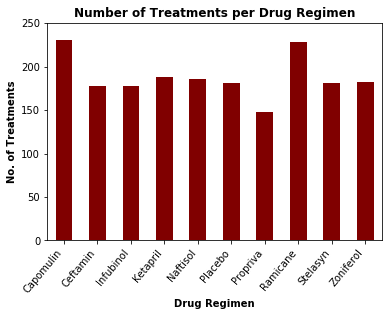

In [24]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
mouse_study_count.plot(kind="bar", color="maroon", width=.5)
plt.xlabel("Drug Regimen", fontweight="black") 
plt.ylabel("No. of Treatments", fontweight="black") 
plt.title("Number of Treatments per Drug Regimen", fontweight="black") 
#Rotation and horizontal alligment of the drug labels
plt.xticks(rotation=50, ha='right')
plt.yticks(np.arange(0, 300, 50))
plt.show()

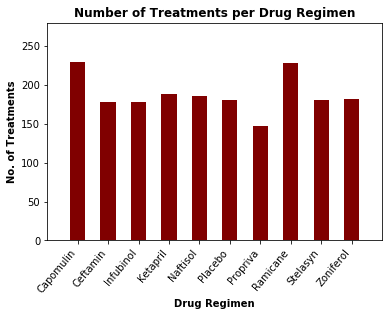

In [25]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.
all_treatments = mouse_study_cleaned.groupby(["Drug Regimen"])["Mouse ID"].count()

# Create a dataframe from the grouped data and reset the index
treatments_and_mice = all_treatments.to_frame().reset_index()

#Plot and customize the bar chart
plt.bar(treatments_and_mice["Drug Regimen"], treatments_and_mice["Mouse ID"], align="center", color="maroon", width =.5)
plt.xlim(-1, len(all_treatments))
plt.ylim(0, max(treatments_and_mice["Mouse ID"])+50)
plt.xlabel("Drug Regimen", fontweight="black") 
plt.ylabel("No. of Treatments", fontweight="black") 
plt.title("Number of Treatments per Drug Regimen", fontweight="black") 
#Rotation and horizontal alligment of the drug labels
plt.xticks(rotation=50, ha='right')
plt.show()


In [98]:
gender_distribution = mouse_study_cleaned.groupby(["Sex"])["Mouse ID"].nunique()
gender_distribution

Sex
Female    123
Male      125
Name: Mouse ID, dtype: int64

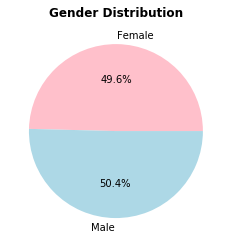

In [99]:
# Pie plot showing the distribution of female versus male mice using pandas
new_colors = ['pink','lightblue']
gender_distribution.plot(kind="pie", autopct='%1.1f%%', colors=new_colors)
plt.title("Gender Distribution", fontweight="black")
#Don't show the Mouse ID x-axis label
plt.axis('off')
plt.show()

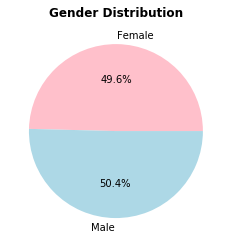

In [100]:
# Pie plot showing the distribution of female versus male mice using pyplot
genders = "Female","Male"
plt.pie(gender_distribution, labels=genders, autopct='%1.1f%%', colors=new_colors)
plt.title("Gender Distribution", fontweight="black") 
plt.show()

## Quartiles, Outliers and Boxplots

In [101]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  Capomulin, Ramicane, Infubinol, and Ceftamin
# Get the last (greatest) timepoint for each mouse
mouseid_groups = mouse_study_cleaned.groupby("Mouse ID")
final_treatments = mouseid_groups["Timepoint"].max()

In [102]:
#Creates a datafame with the drug regimen list and the last timepoint each mouse was treated
mouse_study_final_treatments = pd.merge(final_treatments, mouse_study_cleaned, on=["Mouse ID", "Timepoint"])
#Tumor volume at each mouse's final timepoint
mouse_study_final_treatments[["Mouse ID", "Tumor Volume (mm3)", "Drug Regimen", "Timepoint"]]

,Mouse ID,Tumor Volume (mm3),Drug Regimen,Timepoint
0,a203,67.973419,Infubinol,45
1,a251,65.525743,Infubinol,45
2,a262,70.717621,Placebo,45
3,a275,62.999356,Ceftamin,45
4,a366,63.440686,Stelasyn,30
...,...,...,...,...
243,z435,48.710661,Propriva,10
244,z578,30.638696,Ramicane,45
245,z581,62.754451,Infubinol,45
246,z795,65.741070,Naftisol,45


### Capomulin Quartile Data

In [103]:
# Calculate the final tumor volume of each mouse for Capomulin
capomulin = mouse_study_final_treatments.loc[mouse_study_final_treatments["Drug Regimen"] == "Capomulin"]
capomulin_data = capomulin[["Mouse ID","Tumor Volume (mm3)", "Drug Regimen"]].set_index("Drug Regimen")
capomulin_TV = capomulin_data["Tumor Volume (mm3)"]

#Define the Capomulin quartiles
quartiles = capomulin_TV.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Tumor Volume is: {lowerq}")
print(f"The upper quartile of Tumor Volume is: {upperq}")
print(f"The interquartile range of Tumor Volume is: {iqr}")
print(f"The the median of Tumor Volume is: {quartiles[0.5]} ")

# Determine outliers using upper and lower bounds
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

#Check to see if there are outilers
print(f"Minimum Final Tumor Volume: {capomulin_TV.min()}")
print(f"Maximum Final Tumor Volume: {capomulin_TV.max()}")

capomulin_box = [ tumor_volume for tumor_volume in capomulin_TV ]

The lower quartile of Tumor Volume is: 32.37735684
The upper quartile of Tumor Volume is: 40.1592203
The interquartile range of Tumor Volume is: 7.781863460000004
The the median of Tumor Volume is: 38.125164399999996 
Values below 20.70456164999999 could be outliers.
Values above 51.83201549 could be outliers.
Minimum Final Tumor Volume: 23.34359787
Maximum Final Tumor Volume: 47.68596303


### Ramicane Quartile Data


In [104]:
# Calculate the final tumor volume of each mouse for Ramicane
ramicane = mouse_study_final_treatments.loc[mouse_study_final_treatments["Drug Regimen"] == "Ramicane"]
ramicane_data = ramicane[["Mouse ID","Tumor Volume (mm3)", "Drug Regimen"]].set_index("Drug Regimen")
ramicane_TV = ramicane_data["Tumor Volume (mm3)"]

#Define the Ramicane quartiles
quartiles = ramicane_TV.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Tumor Volume is: {lowerq}")
print(f"The upper quartile of Tumor Volume is: {upperq}")
print(f"The interquartile range of Tumor Volume is: {iqr}")
print(f"The the median of Tumor Volume is: {quartiles[0.5]} ")

# Determine outliers using upper and lower bounds
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

#Check to see if there are outilers
print(f"Minimum Final Tumor Volume: {ramicane_TV.min()}")
print(f"Maximum Final Tumor Volume: {ramicane_TV.max()}")

ramicane_box = [ tumor_volume for tumor_volume in ramicane_TV ]


The lower quartile of Tumor Volume is: 31.56046955
The upper quartile of Tumor Volume is: 40.65900627
The interquartile range of Tumor Volume is: 9.098536719999998
The the median of Tumor Volume is: 36.56165229 
Values below 17.912664470000003 could be outliers.
Values above 54.30681135 could be outliers.
Minimum Final Tumor Volume: 22.05012627
Maximum Final Tumor Volume: 45.22086888


### Infubinol Quartile Data

In [105]:
# Calculate the final tumor volume of each mouse for Infubinol
infubinol = mouse_study_final_treatments.loc[mouse_study_final_treatments["Drug Regimen"] == "Infubinol"]
infubinol_data = infubinol[["Mouse ID","Tumor Volume (mm3)", "Drug Regimen"]].set_index("Drug Regimen")
infubinol_TV = infubinol_data["Tumor Volume (mm3)"]

#Define the Infubinol quartiles
quartiles = infubinol_TV.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Tumor Volume is: {lowerq}")
print(f"The upper quartile of Tumor Volume is: {upperq}")
print(f"The interquartile range of Tumor Volume is: {iqr}")
print(f"The the median of Tumor Volume is: {quartiles[0.5]} ")

# Determine outliers using upper and lower bounds
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

#Check to see if there are outilers
print(f"Minimum Final Tumor Volume: {infubinol_TV.min()}")
print(f"Maximum Final Tumor Volume: {infubinol_TV.max()}")

infubinol_box = [ tumor_volume for tumor_volume in infubinol_TV ]

The lower quartile of Tumor Volume is: 54.04860769
The upper quartile of Tumor Volume is: 65.52574285
The interquartile range of Tumor Volume is: 11.477135160000003
The the median of Tumor Volume is: 60.16518046 
Values below 36.83290494999999 could be outliers.
Values above 82.74144559000001 could be outliers.
Minimum Final Tumor Volume: 36.321345799999996
Maximum Final Tumor Volume: 72.2267309


### Ceftamin Quartile Data

In [106]:
# Calculate the final tumor volume of each mouse for Ceftamin
ceftamin = mouse_study_final_treatments.loc[mouse_study_final_treatments["Drug Regimen"] == "Ceftamin"]
ceftamin_data = ceftamin[["Mouse ID","Tumor Volume (mm3)", "Drug Regimen"]].set_index("Drug Regimen")
ceftamin_TV = ceftamin_data["Tumor Volume (mm3)"]

#Define the Ceftamin quartiles
quartiles = ceftamin_TV.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Tumor Volume is: {lowerq}")
print(f"The upper quartile of Tumor Volume is: {upperq}")
print(f"The interquartile range of Tumor Volume is: {iqr}")
print(f"The the median of Tumor Volume is: {quartiles[0.5]} ")

# Determine outliers using upper and lower bounds
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

#Check to see if there are outilers
print(f"Minimum Final Tumor Volume: {ceftamin_TV.min()}")
print(f"Maximum Final Tumor Volume: {ceftamin_TV.max()}")

ceftamin_box = [ tumor_volume for tumor_volume in ceftamin_TV ]

The lower quartile of Tumor Volume is: 48.72207785
The upper quartile of Tumor Volume is: 64.29983003
The interquartile range of Tumor Volume is: 15.577752179999997
The the median of Tumor Volume is: 59.85195552 
Values below 25.355449580000002 could be outliers.
Values above 87.66645829999999 could be outliers.
Minimum Final Tumor Volume: 45.0
Maximum Final Tumor Volume: 68.92318457


In [117]:
#Making a dataframe with only the four regimens of interest with mouse ID and final tumor volume
first_append = capomulin_data.append(ramicane_data)
add_infubinol = first_append.append(infubinol_data)
final_four_regimen = add_infubinol.append(ceftamin_data).reset_index()
final_four_regimen

,Drug Regimen,Mouse ID,Tumor Volume (mm3)
0,Capomulin,b128,38.982878
1,Capomulin,b742,38.939633
2,Capomulin,f966,30.485985
3,Capomulin,g288,37.074024
4,Capomulin,g316,40.159220
...,...,...,...
95,Ceftamin,x226,45.000000
96,Ceftamin,x581,64.634949
97,Ceftamin,x822,61.386660
98,Ceftamin,y769,68.594745


## Final Four Boxplot

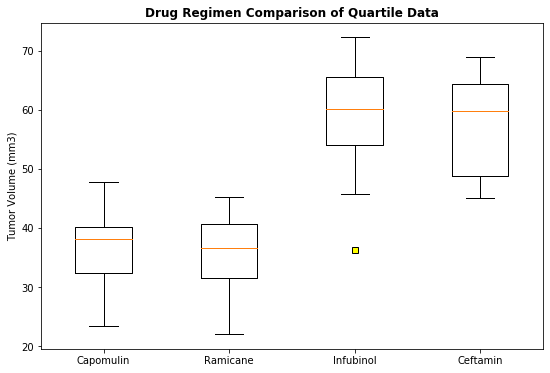

In [130]:
#Thanks to http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/ for helping get all the plots in one figure
# Get the tumor volume data list for the four chosen drug regimens
final_four = [capomulin_box, ramicane_box, infubinol_box, ceftamin_box]

# Put treatment names into a list to use for plot labels
drug_regimen = final_four_regimen["Drug Regimen"].unique()
treatment_list = [ treatment for treatment in drug_regimen ]

#Create a figure instance
fig = plt.figure(1, figsize= (9, 6))

# Create an axes instance
axes = fig.add_subplot(111)

# Create the boxplots and style the outliers
#flierprops argument uses a dictionary with a pair of attributes for styling the outlier markers
axes.boxplot(final_four, flierprops=dict(markerfacecolor='yellow', marker='s'))

#Add boxplot title
axes.set_title("Drug Regimen Comparison of Quartile Data", fontweight="black")

#Add the axes labels
axes.set_xticklabels(treatment_list)
axes.set_ylabel("Tumor Volume (mm3)")
    
plt.show()

## Line and Scatter Plots

In [131]:
# Timepoints and tumor volume data for a mouse using the Capomulin regimen
capomulin_timepoints = mouse_study_cleaned.loc[mouse_study_cleaned["Drug Regimen"] == "Capomulin"]
capomulin_m957_data = capomulin_timepoints.loc[capomulin_timepoints["Mouse ID"] == "m957"]
capomulin_m957_data

,index,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
135,135,m957,Capomulin,Female,3,19,0,45.000000,0
136,136,m957,Capomulin,Female,3,19,5,45.622381,1
137,137,m957,Capomulin,Female,3,19,10,46.414518,1
138,138,m957,Capomulin,Female,3,19,15,39.804453,1
139,139,m957,Capomulin,Female,3,19,20,38.909349,1
140,140,m957,Capomulin,Female,3,19,25,37.695432,1
141,141,m957,Capomulin,Female,3,19,30,38.212479,1
142,142,m957,Capomulin,Female,3,19,35,32.562839,1
143,143,m957,Capomulin,Female,3,19,40,32.947615,1
144,144,m957,Capomulin,Female,3,19,45,33.329098,1


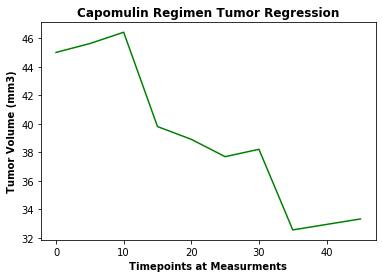

In [132]:
# Line plot of time point versus tumor volume for a mouse treated with Capomulin
x_axis = capomulin_m957_data["Timepoint"]
y_axis = capomulin_m957_data["Tumor Volume (mm3)"]
plt.plot(x_axis, y_axis, color="green")
plt.xlabel("Timepoints at Measurments", fontweight="black") 
plt.ylabel("Tumor Volume (mm3)", fontweight="black") 
plt.title("Capomulin Regimen Tumor Regression", fontweight="black")
plt.show()

In [133]:
# Weight and average tumor volume data for the Capomulin regimen
capomulin_data = mouse_study_cleaned.loc[mouse_study_cleaned["Drug Regimen"] == "Capomulin"]
capomulin_data_avg = capomulin_data.groupby("Mouse ID")["Weight (g)", "Tumor Volume (mm3)"].mean()

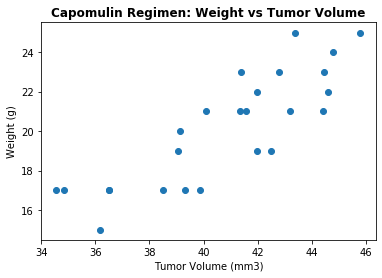

In [134]:
#Defining the x and y axis for the scatter plot
mouse_weight = capomulin_data_avg["Weight (g)"]
tumor_volume = capomulin_data_avg["Tumor Volume (mm3)"]

# Capomulin regimen scatter plot of mouse weight versus average tumor volume
plt.scatter(tumor_volume, mouse_weight)
plt.xlabel("Tumor Volume (mm3)") 
plt.ylabel("Weight (g)") 
plt.title("Capomulin Regimen: Weight vs Tumor Volume", fontweight = "black")
plt.show()

## Correlation and Regression

The correlation between both factors is 0.84
The r-squared is: 0.7088568047708717


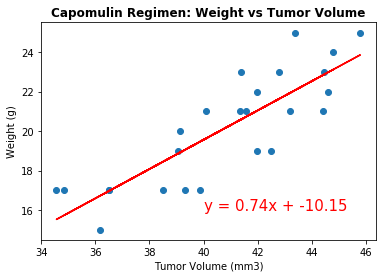

In [135]:
# Caclutating the correlation coefficient for mouse weight and average tumor volume
correlation = st.pearsonr(tumor_volume, mouse_weight)

# Calculating the linear regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(tumor_volume, mouse_weight)
regress_values = tumor_volume * slope + intercept

# Creating the linear regressing equation to add to the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Capomulin regimen scatter plot of mouse weight versus average tumor volume
plt.scatter(tumor_volume, mouse_weight)

# Adding the linear regression line
plt.plot(tumor_volume,regress_values,"r-")
plt.xlabel("Tumor Volume (mm3)") 
plt.ylabel("Weight (g)") 
plt.title("Capomulin Regimen: Weight vs Tumor Volume", fontweight = "black")

#Placing the linear regression equation on the plot
plt.annotate(line_eq,(40,16),fontsize=15,color="red")

print(f"The correlation between both factors is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
plt.show()